In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
from zipfile import ZipFile
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [31]:
# compute percentage red/green/blue
def getRGBPercentage(image):
    RGBtuple = np.array(image).mean(axis=(0,1))    # compute mean for each red/green/blue
    sumRGB = RGBtuple.sum()                        # total RGB
    
    # compute percentage red/green/blue
    red_pct = RGBtuple[0] / sumRGB
    green_pct = RGBtuple[1] / sumRGB
    blue_pct = RGBtuple[2] / sumRGB
    
    return (red_pct, green_pct, blue_pct)

In [32]:
flower_types = []
image_list = []
image_widths = []
image_heights = []
image_pixels = []
image_modes = []
red_pcts = []
green_pcts = []
blue_pcts = []

# open the zip file and load the images
with ZipFile('/content/drive/MyDrive/Colab Notebooks/data/flower_dataset.zip', 'r') as zfile:
    # iterate through every image file in the archive
    for filename in tqdm(zfile.namelist()):
        # split the file name
        filename_list = filename.split('/')
        # get the class name
        flower_types.append(filename_list[-2])
        
        # open the image and save to image_list
        with zfile.open(filename) as image_file:
            # load the image
            image = Image.open(image_file)
            
            # get image's size
            img_width, img_height = image.size
            image_widths.append(img_width)
            image_heights.append(img_height)
            
            # compute image's pixels and get image's mode
            image_pixels.append(img_width*img_height)
            image_modes.append(image.mode)

            # convert image to numpy array
            image_np = np.asarray(image)

            # resize the image and append to image_list
            #image_resize = cv2.resize(image_np, (80, 80))

            # reshape the image to proper version for the following processing
            #image_reshape = image_resize.reshape((image_resize.shape[0] * image_resize.shape[1], 3))
            image_list.append(image_np)
            #image_resizes.append(image_resize)
            #image_reshapes.append(image_reshape)
            
            # get percentage of red/green/blue of original image
            red_pct, green_pct, blue_pct = getRGBPercentage(image)
            red_pcts.append(red_pct)
            green_pcts.append(green_pct)
            blue_pcts.append(blue_pct)

# create a Pandas dataframe that contains image information
df = pd.DataFrame(dict({'Image': image_list,
                        'Flower Type': flower_types, 
                        'Image Width': image_widths, 
                        'Image Height': image_heights,
                        'Image Pixels': image_pixels,
                        'Image Mode': image_modes,
                        'Red %': red_pcts,
                        'Green %': green_pcts,
                        'Blue %': blue_pcts}))

# look at the first five rows of data
df.head()

100%|██████████| 4317/4317 [00:25<00:00, 167.96it/s]


,Image,Flower Type,Image Width,Image Height,Image Pixels,Image Mode,Red %,Green %,Blue %
0,"[[[135, 135, 133], [138, 138, 136], [142, 142,...",daisy,320,263,84160,RGB,0.353741,0.353416,0.292843
1,"[[[213, 220, 228], [212, 212, 220], [207, 207,...",daisy,500,313,156500,RGB,0.366127,0.348112,0.285762
2,"[[[138, 132, 120], [131, 127, 115], [132, 130,...",daisy,320,215,68800,RGB,0.332936,0.284915,0.382149
3,"[[[27, 16, 82], [26, 15, 81], [26, 15, 81], [2...",daisy,500,333,166500,RGB,0.318637,0.256794,0.424569
4,"[[[32, 51, 32], [29, 46, 30], [30, 43, 33], [2...",daisy,320,250,80000,RGB,0.318229,0.337162,0.344609


In [33]:
# look at the shape of data
df.shape

(4317, 9)

## Data Distribution

In [34]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

flower_counts = df['Flower Type'].value_counts()

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=1, specs=[[{'type':'domain'}]])
fig.add_trace(go.Pie(labels=flower_counts.index, values=flower_counts.values, name="Flower"),1, 1)

# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name",
                  textposition='inside', textinfo='value+percent+label')

# Add annotations in the center of the donut pies.
fig.update_layout(annotations=[dict(text='Flower<br />Dataset', x=0.5, y=0.5, font_size=20, showarrow=False)])
fig.show()

## Descriptive Statistics

In [35]:
# display descriptive statistics of data
statistics = df.describe().T[['min', 'max', 'mean', '50%', 'std']]
statistics.rename(columns={'min': 'Min', 'max': 'Max', 'mean': 'Mean', '50%': 'Median', 'std':'Standard Deviation'},
                  inplace=True)
statistics['Range'] = statistics['Max'] - statistics['Min']
#statistics[:3] = np.round(statistics[:3])
statistics[['Range', 'Min', 'Max', 'Mean', 'Median', 'Standard Deviation']]

,Range,Min,Max,Mean,Median,Standard Deviation
Image Width,890.000000,134.000000,1024.000000,338.379893,320.000000,119.067232
Image Height,362.000000,80.000000,442.000000,253.073662,240.000000,61.558205
Image Pixels,201800.000000,19200.000000,221000.000000,91445.254112,76480.000000,52130.492116
Red %,0.888605,0.084733,0.973338,0.395124,0.377033,0.079271
Green %,0.807317,0.010713,0.818030,0.358717,0.355041,0.060148
Blue %,0.623759,0.003307,0.627066,0.246159,0.260725,0.083258


In [36]:
import plotly.express as px

def build_histogram(data, x_label):
    fig = px.histogram(data, x=x_label, marginal="violin")
    fig.update_layout(
        title_text='Frequency Distribution of ' + x_label, # title of plot
        xaxis_title_text=x_label, # xaxis label
        yaxis_title_text='Frequency', # yaxis label
        bargap=0.1, # gap between bars of adjacent location coordinates
        #bargroupgap=0.1 # gap between bars of the same location coordinates
    )
    fig.show()

In [37]:
build_histogram(df, 'Image Pixels')

## Percentage of Red / Green / Blue

In [38]:
fig = px.scatter(df, x="Red %", y="Green %", color="Flower Type", facet_col="Flower Type")
fig.show()

In [39]:
fig = px.scatter(df, x="Red %", y="Blue %", color="Flower Type", facet_col="Flower Type")
fig.show()

## Dominant Colors per Flower Type

In [40]:
def restructure_list(image_list_in):
    """
    Restructures list into vstack array of shape
    M samples x N features for sklearn
    """
    
    # set vStack to the first image in the list
    vStack = image_list_in[0]

    # iterate through the remaining images in the list
    for image in image_list_in[1:]:
        # stack arrays in sequence vertically (row wise).
        vStack = np.vstack((vStack, image))
    
    return vStack

In [41]:
def reshape_images(data):
    # reshape the image to proper version for retrieving dominant colors

    image_list = []
    for image in data['Image'].tolist():
        # resize the image to a smaller size for faster processing
        image_resize = cv2.resize(image, (24, 24))
        # reshape the image to proper version for retrieving dominant colors
        image_reshape = image_resize.reshape((image_resize.shape[0] * image_resize.shape[1], 3))
        image_list.append(image_reshape)
    
    # return a list of reshaped images
    return image_list

### Within-Cluster Sum of Square (WCSS)

Build a list of WCSS for each flower type dataset.

In [42]:
from sklearn.cluster import KMeans

def build_wcss_list(image_list_in):
    # a list of Within-Cluster Sum of Square 
    wcss = []

    # get wcss for each k value
    k_values = list(range(1, 11))
    for i in tqdm(k_values): 
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(image_list_in) 
        wcss.append(kmeans.inertia_)
    
    return wcss

In [43]:
# get a list of flower types
flower_types = list(df['Flower Type'].unique())
image_reshaped_list = []

# build a wccs list for each flower type
wccs_list = []
for flower_type in flower_types:
    if flower_type == 'All Flowers':
        img_list = restructure_list(reshape_images(df))
    else:
        img_list = restructure_list(reshape_images(df[df['Flower Type'] == flower_type]))

    image_reshaped_list.append(img_list)
    wccs_list.append(build_wcss_list(img_list))

100%|██████████| 10/10 [02:23<00:00, 14.35s/it]


### Select Best K Value for Each Flower Type Dataset

In [44]:
import plotly.graph_objects as go

for i, wccs in enumerate(wccs_list):
    k_values = list(range(1, 11))
    wccs_log = np.log(wccs)
    fig = go.Figure(data=go.Scatter(x=k_values, y=wccs_log))
    fig.update_layout(
        title_text='Flower Type: ' + flower_types[i], # title of plot
        xaxis_title_text='Number of Clusters (k)', # xaxis label
        yaxis_title_text='Log of WCSS', # yaxis label
        width=600, height=400,
        shapes=[dict(type="line",
                 xref='x1',
                 yref='y1',
                 x0=k_values[0],
                 y0=wccs_log[0],
                 x1=k_values[-1],
                 y1=wccs_log[-1],
                 line=dict(color="Red", width=2, dash='dash'),
                 ),
            ],
    )
    fig.show()

In [45]:
# select the best k value based on the graphs above
best_k_values = [3, 5, 3, 5, 3]

### Plot Dominant Colors for each Flower Type Dataset

In [46]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    
    # return the histogram
    return hist

In [47]:
def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    
    # loop over the percentage of each cluster and the color of each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
    
    # return the bar chart
    return bar

In [48]:
def plot_dominant_colors(image_list_in, k):
    # cluster the pixel intensities
    clt = KMeans(n_clusters=k, random_state=42)
    clt.fit(image_list_in)

    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    hist = centroid_histogram(clt)
    bar = plot_colors(hist, clt.cluster_centers_)

    # show our color bar
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()

daisy


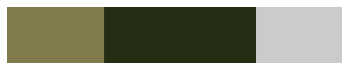

dandelion


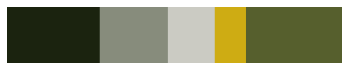

rose


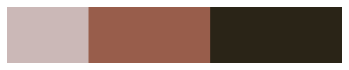

sunflower


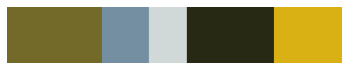

tulip


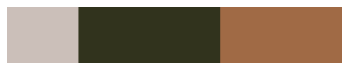

In [49]:
for i, k in enumerate(best_k_values):
    #img_list = restructure_list(reshape_images(df[df['Flower Type'] == flower_types[i]]))
    print(flower_types[i])
    plot_dominant_colors(image_reshaped_list[i], k)

## Bag of Visual Words

In [50]:
# defining feature extractor that we want to use (ORB feature used in this extractor)
def features(image):
    extractor = cv2.ORB_create()
    keypoints, descriptors = extractor.detectAndCompute(image, None)
    return keypoints, descriptors

In [51]:
# the code below is obtained from 
# https://github.com/kushalvyas/Bag-of-Visual-Words-Python/blob/master/helpers.py
# with minor modification
def developVocabulary(descriptor_list, kmeans_ret, n_images=10, n_clusters=30):
    """
    Each cluster denotes a particular visual word.
    Every image can be represeted as a combination of multiple visual words. 
    The best method is to generate a sparse histogram that contains the frequency of occurence of each visual word.
    Thus the vocabulary comprises of a set of histograms of encompassing all descriptions for all images.
    """

    # create an array that store the visual words
    mega_histogram = np.array([np.zeros(n_clusters) for i in range(n_images)])
    old_count = 0
    
    for i in range(n_images):
        # get the size of descriptor
        des_list = len(descriptor_list[i])
        
        for j in range(des_list):
            idx = kmeans_ret[old_count+j]    # get the index of the visual word
            mega_histogram[i][idx] += 1      # increment the count for the visual word
        
        # update old_count
        old_count += des_list

    return mega_histogram

In [52]:
# the code below is obtained from 
# https://github.com/kushalvyas/Bag-of-Visual-Words-Python/blob/master/helpers.py
# with minor modification
def plotHist(vocabulary, n_clusters=30):
    '''Plot the mega histogram'''
    
    # value for x-axis would be the index of the visual found in the Bag-of-Visual Words
    x_scalar = np.arange(n_clusters)
    
    # value for y-axis would be the frequency of the visual 
    y_scalar = np.array([abs(np.sum(vocabulary[:,h], dtype=np.int32)) for h in range(n_clusters)])
    
    # set figure's size
    plt.figure(figsize=(12,6))
    
    # create a bar plot of the vocabulary
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar, x_scalar)
    plt.show()

In [53]:
#data_subset = df[df['Flower Type'] == 'daisy']

# get a list of file in "images" directory
images = []                # a list of images
descriptor_list = []       # a list of descriptors

# iterate through every file in the "images" directory
#for image in data_subset['Image']:
    #image = cv2.imread('images/' + image_file, 0)    # read the image
    #images.append(image)                             # append the image to "images" list
#    kp, descriptor = features(image)                 # get image's features
#    descriptor_list.append(descriptor)               # append image's feature to the descriptor list

# build a KMeans model
#kmeans = KMeans(n_clusters=30, random_state=42)
#kmeans_ret = kmeans.fit_predict(restructure_list(descriptor_list))

# build Bag-of-Visual Words
#mega_histogram = developVocabulary(descriptor_list, kmeans_ret)

# plot the histogram
#plotHist(mega_histogram)